(-66.58068711586749, 38.36317557694608, -46.33763488054455, 49.373506422883075)

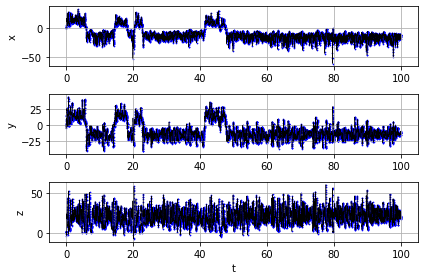

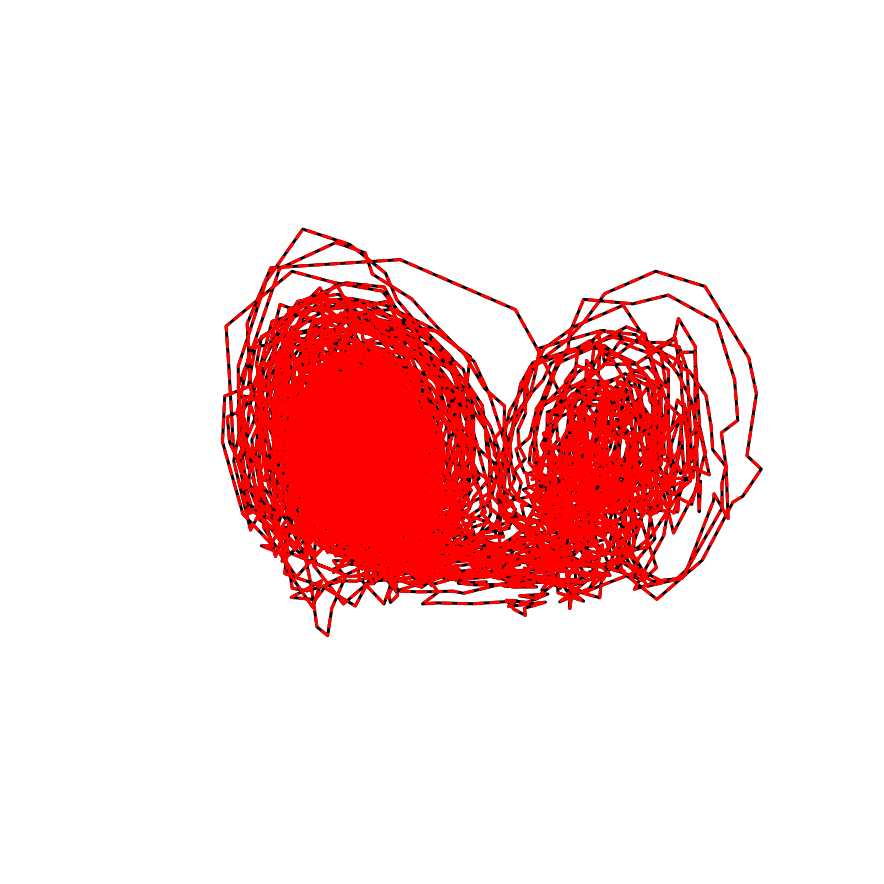

In [39]:

import sys
sys.path.append("/Users/lana_g/Downloads/modified-SINDy-master/Lorenz")
"""
Created on Mon May 25 00:26:35 2020

@author: kahdi
"""
#%% Import packages
import numpy as np
from scipy.integrate import odeint
import tensorflow as tf
import matplotlib.pyplot as plt
from utils_NSS_SINDy import *
import time
import tensorflow_probability as tfp
from datetime import datetime

#%% Define how many percent of noise you need
NoisePercentage=0.1

#%% Simulate
# Define the random seed for the noise generation
np.random.seed(4)

# Define the parameters
p0=np.array([-10.0,10.0,28.0,-1.0,-1.0,1.0,-8/3])

# Define the initial conditions
#x0=np.array([5.0,5.0,25.0])

# Define the time points
T=100.0
dt=0.01

t=np.linspace(0.01,T,int(T/dt))

# Now simulate the system
#x=odeint(Lorenz,x0,t,args=(p0,),rtol = 1e-12, atol = 1e-12)
#dx=np.transpose(Lorenz(np.transpose(x), 0, p0))

# Get the size info
#stateVar,dataLen=np.transpose(x).shape

# Generate the noise

# Add the noise and get the noisy data
#xn=x+Noise


import pandas as pd
datax = pd.read_csv("/Users/lana_g/Downloads/comparison/Lorenz_x_stochastic_gamma05_withlib.csv", header = None)
ddatax = pd.read_csv("/Users/lana_g/Downloads/comparison/Lorenz_dx_stochastic_gamma05.csv", header = None)
x0 = datax.values[0,0:3]
x = datax.values[0:10000,0:3]
# Generate the noise
dataLen, stateVar = x.shape

NoiseMag=[np.std(x[:,i])*NoisePercentage*0.01 for i in range(stateVar)]
Noise=np.hstack([NoiseMag[i]*np.random.randn(dataLen,1) for i in range(stateVar)])

xn = datax.values[0:10000,0:3]+Noise
dx = ddatax.values[0:10000,0:3]



# Test the SINDy
N_SINDy_Iter=15
disp=0
NormalizeLib=0
libOrder=2
lam=0.2

# SoftStart?
softstart=0

#%% Now plot the result of Lorenz

plt.figure()

plt.subplot(3,1,1)
pp1=plt.plot(t,x[:,0],linewidth=0.5,color='k')
pp1=plt.scatter(t,xn[:,0],s=0.5,color='b')
plt.ylabel('x')
plt.grid(True)

plt.subplot(3,1,2)
pp2=plt.plot(t,x[:,1],linewidth=0.5,color='k')
pp1=plt.scatter(t,xn[:,1],s=0.5,color='b')
plt.ylabel('y')
plt.grid(True)

plt.subplot(3,1,3)
pp3=plt.plot(t,x[:,2],linewidth=0.5,color='k')
pp1=plt.scatter(t,xn[:,2],s=0.5,color='b')
plt.ylabel('z')
plt.xlabel('t')
plt.tight_layout()
plt.grid(True)

#%%
lw=3
plt.figure(figsize=(20,16))
pp4=plt.axes(projection='3d')
pp4.plot3D(x[:,0],x[:,1],x[:,2], color='black',linewidth=lw)
pp4.plot3D(xn[:,0],xn[:,1],xn[:,2], color='red',linestyle='--',linewidth=3)
pp4.view_init(0, -30)
pp4.grid(False)
pp4.axis('off')
#plt.savefig('p1.pdf')








The GPU is not available






The first dimension of the input data: 10000
The second dimension of the input data: 3
[[ -7.45992163 -32.69902875 158.42271589]
 [  4.20386291  -0.9315458   -1.00120466]
 [  2.69649499   0.          -8.17923572]
 [  0.           0.           0.        ]
 [ -0.22478415   0.           0.90471277]
 [  0.          -0.88530172   0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.75382058   7.82265641 -22.19025713]
 [  0.           0.           0.        ]
 [ -0.33844391  -7.64279289  22.40724836]]


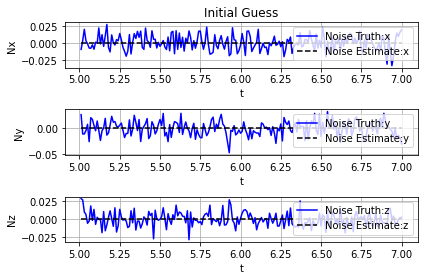

In [40]:

#%% Define a neural network
# Check the GPU status
CheckGPU()

# Define the data type
dataType=tf.dtypes.float32

dh=tf.constant(dt)

#%% Define the data
# Define the prediction step
q=1

# Get the middel part of the measurement data (it will be define as constant)
Y=tf.constant(xn,dtype=dataType)
Y0=tf.constant(GetInitialCondition(xn,q,dataLen),dtype=dataType)

# Ge the forward and backward measurement data (it is a constant that wouldn't change)
Ypre_F,Ypre_B=SliceData(xn,q,dataLen)
Ypre_F=tf.constant(Ypre_F,dtype=dataType)
Ypre_B=tf.constant(Ypre_B,dtype=dataType)

# Get the weight for the error
ro=0.9
weights=tf.constant(DecayFactor(ro,stateVar,q),dtype=dataType)

if softstart==1:
    # Soft Start
    NoiseEs,xes=approximate_noise(np.transpose(xn), 20)
    NoiseEs=np.transpose(NoiseEs)
    xes=np.transpose(xes)
else:
    # Hard Start
    NoiseEs=np.zeros((xn.shape[0],xn.shape[1]))
    xes=xn-NoiseEs

dxes=CalDerivative(xes,dt,1)

# Get the initial guess of noise, we make a random guess here. For beteer performance you could first smooth the data and guess the noise. 
NoiseVar=tf.Variable(NoiseEs,dtype=tf.dtypes.float32)

# Get the initial guess of the SINDy parameters
Theta1=Lib(xes,libOrder)
Theta = np.hstack((Theta1,datax.values[0:10000,3:6]))


Xi0=SINDy(Theta,dxes,lam,N_SINDy_Iter,disp,NormalizeLib)

print(Xi0)

#%%
# Define the initial guess of the selection parameters
Xi=tf.Variable(Xi0,dtype=dataType)

# Set the initial active matrix
Xi_act=tf.constant(np.ones(Xi0.shape),dtype=dataType)

#%% First plot the noise: true v.s. identified
StartIndex=500 # Choose how many noise data point you would like to plot
EndIndex=700

plt.figure()
plt.subplot(3,1,1)
plt.title("Initial Guess")
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,0],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseVar.numpy()[StartIndex:EndIndex,0],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Nx')
plt.xlabel('t')
plt.legend(['Noise Truth:x', 'Noise Estimate:x'],loc='upper right')
plt.grid(True)

plt.subplot(3,1,2)
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,1],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseVar.numpy()[StartIndex:EndIndex,1],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Ny')
plt.xlabel('t')
plt.legend(['Noise Truth:y', 'Noise Estimate:y'],loc='upper right')
plt.grid(True)

plt.subplot(3,1,3)
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,2],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseVar.numpy()[StartIndex:EndIndex,2],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Nz')
plt.xlabel('t')
plt.legend(['Noise Truth:z', 'Noise Estimate:z'],loc='upper right')
plt.grid(True)
plt.tight_layout()
#plt.savefig('Result_NSS_SwipeNoiseLevel\Plots\Percent'+str(NoisePercentage)+'.pdf')

#%% Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=1e-09)

In [41]:

#%% Finally start training!
Nloop=5
N_train=10000

# Set a list to store the noise value
NoiseList=[]
NoiseIDList_SingleRun=[]
TrainTimeList_SingleRun=np.zeros((Nloop,1))
Enoise_error_List_SingleRun=np.zeros((Nloop,1))
Evector_field_error_list_SingleRun=np.zeros((Nloop,1))
Epre_error_list_SingleRun=np.zeros((Nloop,1))
x_sim_list_SingleRun=[]
Xi_List_SingleRun=[]

for k in range(Nloop):
    print("Runing the loop ",str(k+1))
    # Denoise the signal
    NoiseID,totalTime=Train_NSS_SINDy(Y,Y0,Ypre_F,Ypre_B,NoiseVar,Xi,Xi_act,weights,dt,q,stateVar,dataLen,optimizer,N_train)
    
    print("\t Current loop takes ",totalTime)

    # After the first iteration, minus the noise identified from the noisy measurement data
    xes=xn-NoiseID
    xes=xes[q+1:-q-1,:]
    dxes=CalDerivative(xes,dt,1)
         
    print("Current Xi result")
    print(Xi)
    
    # Do SINDy on the denoised data
    Theta1=Lib(xes,libOrder)
    Theta = np.hstack((Theta1,datax.values[0:int(xes.shape[1]),3:6]))
    
    Xi0=SINDy(Theta,dxes,lam,N_SINDy_Iter,disp,NormalizeLib)
    
    # Do SINDy on the denoised data
    index_min=abs(Xi.numpy())>lam
    Xi_act_dum=Xi_act.numpy()*index_min.astype(int)
    Xi_num=Xi.numpy()
    Xi_num=Xi_num*Xi_act_dum
    index_min=Xi_act_dum.astype(bool)
    
    # Regress
    for r in range(xes.shape[1]):
        Xi_num[index_min[:,r],r]=solve_minnonzero(Theta[:,index_min[:,r]],dxes[:,r])
    
    # Print the new initial start point
    print("New Xi result")
    print(Xi_num)
    
    # Determine which term should we focus on to optimize next
    Xi_act=tf.constant(Xi_act_dum,dtype=tf.dtypes.float32)
    Xi=tf.Variable(Xi_num,dtype=tf.dtypes.float32)
    
    # Calculate the performance
    Enoise_error,Evector_field_error,Epre_error,x_sim=ID_Accuracy_SINDy(x,dx,Noise,NoiseID,LibGPU,Xi,dataLen,dt)
    
    # Print the performance
    print("\t\t The error between the true noise and estimated noise is:",Enoise_error,"\n")
    print("\t\t The error between the true vector field and estimated vector field is:",Evector_field_error,"\n")
    print("\t\t The error between the true trajector and simulted trajectory is:",Epre_error,"\n")
    
    NoiseIDList_SingleRun.append(NoiseID)
    x_sim_list_SingleRun.append(x_sim)
    TrainTimeList_SingleRun[k]=totalTime
    Enoise_error_List_SingleRun[k]=Enoise_error
    Evector_field_error_list_SingleRun[k]=Evector_field_error
    Epre_error_list_SingleRun[k]=Epre_error
    Xi_List_SingleRun.append(Xi.numpy())
    
#%% Now plot the noise signal speration result

# First plot the noise: true v.s. identified
StartIndex=500 # Choose how many noise data point you would like to plot
EndIndex=700

plt.figure()
plt.subplot(3,1,1)
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,0],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseID[StartIndex:EndIndex,0],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Nx')
plt.xlabel('t')
plt.legend(['Noise Truth:x', 'Noise Estimate:x'],loc='upper right')
plt.grid(True)

plt.subplot(3,1,2)
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,1],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseID[StartIndex:EndIndex,1],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Ny')
plt.xlabel('t')
plt.legend(['Noise Truth:y', 'Noise Estimate:y'],loc='upper right')
plt.grid(True)

plt.subplot(3,1,3)
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,2],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseID[StartIndex:EndIndex,2],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Nz')
plt.xlabel('t')
plt.legend(['Noise Truth:z', 'Noise Estimate:z'],loc='upper right')
plt.grid(True)
plt.tight_layout()
#plt.savefig('Percent'+str(NoisePercentage)+'.pdf')

#%%
n_bins=int(180/5)
x_scale=np.linspace(-4*max(NoiseMag), 4*max(NoiseMag), 1000)

plt.figure()
plt.subplot(3,1,1)
plt.grid(True)
pp6=plt.hist(Noise[:,0], bins = n_bins, color = 'blue', alpha=0.9,edgecolor = 'black',density=True)
pp6=plt.hist(NoiseID[:,0], bins = n_bins, color = 'orange', alpha=0.75,edgecolor = 'black',density=True)
#pp6=plt.plot(x_scale,0.5*Gaussian(x_scale, 0, NoiseMag[0]),color ='black',alpha=0.9,linewidth=2.5)
plt.ylabel('Frequency')
plt.xlabel('Noise:x')
axes = plt.gca()
axes.set_xlim([-4*max(NoiseMag),4*max(NoiseMag)])
#axes.set_ylim([0,0.65])

plt.subplot(3,1,2)
plt.grid(True)
pp6=plt.hist(Noise[:,1], bins = n_bins, color = 'blue', alpha=0.9,edgecolor = 'black',density=True)
pp6=plt.hist(NoiseID[:,1], bins = n_bins, color = 'orange', alpha=0.75,edgecolor = 'black',density=True)
#pp6=plt.plot(x_scale,0.5*Gaussian(x_scale, 0, NoiseMag[1]),color ='black',alpha=0.9,linewidth=2.5)
plt.ylabel('Frequency')
plt.xlabel('Noise:y')
axes = plt.gca()
axes.set_xlim([-4*max(NoiseMag),4*max(NoiseMag)])
#axes.set_ylim([0,0.65])

plt.subplot(3,1,3)
plt.grid(True)
pp6=plt.hist(Noise[:,2], bins = n_bins, color = 'blue', alpha=0.9,edgecolor = 'black', density=True)
pp6=plt.hist(NoiseID[:,2], bins = n_bins, color = 'orange', alpha=0.75,edgecolor = 'black', density=True)
#pp6=plt.plot(x_scale,0.5*Gaussian(x_scale, 0, NoiseMag[2]),color ='black',alpha=0.9,linewidth=2.5)
plt.ylabel('Frequency')
plt.xlabel('Noise:z')
axes = plt.gca()
axes.set_xlim([-4*max(NoiseMag),4*max(NoiseMag)])
#axes.set_ylim([0,0.65])
plt.tight_layout()
plt.savefig("p6.pdf")
#plt.savefig('Percent'+str(NoisePercentage)+'_Distribution.pdf')

#%%
plt.figure(figsize=(20,16))
pp4=plt.axes(projection='3d')
pp4.plot3D(x[:,0], x[:,1], x[:,2], color='black',linewidth=4.5)
pp4.plot3D((xn-NoiseID)[:,0], (xn-NoiseID)[:,1], (xn-NoiseID)[:,2], color='orange',linestyle='--',linewidth=4.5)
pp4.view_init(0, -30)
pp4.grid(False)
pp4.axis('off')
plt.savefig('p1.pdf')
#plt.savefig("Lorenz_Denoised_NoiseLevel_"+str(NoisePercentage)+".pdf")


#%%
Enoise_error,Evector_field_error,Epre_error,x_sim=ID_Accuracy_SINDy(x,dx,Noise,NoiseID,LibGPU,Xi,dataLen,dt)

print("The error between the true noise and estimated noise is:",Enoise_error)
print("The error between the true vector field and estimated vector field is:",Evector_field_error)
print("The error between the true trajector and simulted trajectory is:",Epre_error)

#%%
fontSize=60
plt.rc('xtick', labelsize=fontSize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontSize) 

preLen=500
plt.figure(figsize=(30,25))
pp5=plt.axes(projection='3d')
pp5.plot3D(x[1:preLen+1,0], x[1:preLen+1,1], x[1:preLen+1,2], color='black',linewidth=8)
pp5.plot3D(x_sim[0:preLen,0], x_sim[0:preLen,1], x_sim[0:preLen,2], color='m',linestyle='--',linewidth=8)
pp5.plot([x[0,0]], [x[0,1]], [x[0,2]], markerfacecolor='black', markeredgecolor='orange', marker='*', markeredgewidth=5,markersize=60, alpha=1)
pp5.view_init(30, -30)
pp5.grid(True)
pp5.axis('on')
pp5.set_facecolor("white")

Epre_short=np.linalg.norm(x[1:preLen+1]-x_sim[0:preLen],'fro')**2/np.linalg.norm(x[1:preLen+1],'fro')**2

print("The short term prediction error is:",Epre_short)

#plt.savefig("NN_Lorez_Pre_LongTrain.pdf")

#%%
fontSize=10
plt.rc('xtick', labelsize=fontSize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontSize) 

plt.figure()
plt.plot(Enoise_error_List_SingleRun)
plt.ylabel('NoiseID Error')
plt.xlabel('Loop Index')

plt.figure()
plt.plot(Evector_field_error_list_SingleRun)
plt.ylabel('Derivative Error')
plt.xlabel('Loop Index')

plt.figure()
plt.plot(Epre_error_list_SingleRun)
plt.ylabel('Simulation Error')
plt.xlabel('Loop Index')



Runing the loop  1


TypeError: 'NoneType' object is not callable